# Biodiversity Intactness Index change in Phoenix subdivision

Author: Melissa Widas

Repository: https://github.com/mwidas/phoenix-biodiversity-change

## About

In this notebook we will investigate changes for a biodiversity intactness index (BII) between 2017 and 2020 for the Phoenix, Arizona subdivision area. 

In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001. Urban sprawl creates pressure on biodiversity and natural areas. Thus, we will be exploring if the Biodiversity Intactness Index (BII) reflects these trends.

## Highlights
- Access data from the Microsoft planetary computer
- Geospatial data wrangling using `rioxarray`
- Customizing a map using `matplotlib`


## About the Data

In this notebook two datasets are used

### BII data:

 The first dataset is part of the Microsoft Planetary Computer (MPC) STAC catalog. The dataset is generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. For this analysis we will use the data assets for the 2020 and 2017 Biodiversity Intactness surveys.


### Phoenix subdivision data

The second dataset used will be polygons of subdivisions in Arizona, United States. This dataset has been downloaded as a shapefile from the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona from the [TIGER shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions).

## Final Outputs

The final visualization for this notebook are the following maps showing the location of the Phoenix, Arizona subdivision and the change in BII between 2017 and 2020.

### Location of Phoenix, AZ
![alternative text](images/arizona_map.png)

### The percent change of BII of Phoenix, AZ subdivision from 2017 to 2020

![alternative text](images/BII_phoenix.png)


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends
import os 

from shapely.geometry import Polygon


from pystac_client import Client # used to access STAC catalogs

import planetary_computer # used to sign items from the MPC STAC catalog

# ----- other libraries for nice ouputs
from IPython.display import Image


## Creating Map of Phoenix, AZ Percentage BII Change

### Import Data

#### Import Data from Microsoft Planetary Computer

In [3]:
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# access the io-biodiversity collection
io_biodiversity_collection = catalog.get_child('io-biodiversity')
io_biodiversity_collection

<CollectionClient id=io-biodiversity>

In [5]:
# temporal range of interest
time_range = "2017-01-01/2020-01-01"
# spatial range of interest
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

search = catalog.search(collections=['io-biodiversity'], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

/Users/melissawidas/opt/anaconda3/envs/mpc-env/lib/python3.11/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


4

In [6]:
# look at items to determine how to store our data
items

In [7]:
# create data for bii 2020
bii_2020 = items[0]

# create data for bii 2017
bii_2017 = items[3]

In [8]:
# print item id and properties for BII 2017 to investigate projection
print('id:' , bii_2017.id)

bii_2017.properties


id: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

In [9]:
# look at assets to find where data is stored
for key in bii_2017.assets.keys():
    print(key, '--', bii_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [10]:
# load BII 2017 data
bii_2017_data = rioxr.open_rasterio(bii_2017.assets['data'].href)

# plot data to look at it
#bii_2017_data.plot()


In [11]:
# load BII 2020 data
bii_2020_data = rioxr.open_rasterio(bii_2020.assets['data'].href)

# plot data to look at it
# bii_2020_data.plot()



### Import Data From .shp

The subdivisions shapefile will be used to narrow our scope to the Phoenix, AZ subdivision.

In [12]:
# import dataset from data directory
subdivisions = gpd.read_file(os.path.join(os.getcwd(), 'data', 'tl_2022_04_cousub','tl_2022_04_cousub.shp'))

# create a subset of Phoenix, AZ
phoenix = subdivisions[subdivisions.NAME=='Phoenix']

# verify the shape of Phoenix, AZ subdivision
#phoenix.plot()

# change the crs of phoenix to the crs of the raster files
phoenix = phoenix.to_crs(bii_2017_data.rio.crs)

### Clip Data to Phoenix Subdivision

In [13]:
# clip 2017 BII raster to geometry of phoenix
bii_2017_phoenix = bii_2017_data.rio.clip(phoenix['geometry'])

# clip 2020 BII raster to geometry of phoenix
bii_2020_phoenix = bii_2020_data.rio.clip(phoenix['geometry'])


### Calculate Percentage of BII for Phoenix, AZ subdivision for 2017 and 2020

In [14]:
# calculate the percentage of area of Phoenix with a BII of at least 0.75 in 2017
# assign data equal or greater to 0.75 True and all else false
above_2017_bool = bii_2017_phoenix>=0.75
above_2017_bool.head

# assign data with True as 1 and False as 0
above_2017 = above_2017_bool.astype('int')
above_2017.head

# calculate number of pixels that have a BII>=0.75
pixels_2017 = above_2017.values.sum()

# calculate total number of pixels for 2017
total_pixels_2017 = above_2017.rio.width * above_2017.rio.height

# calculate percentage
percentage_2017=(pixels_2017/total_pixels_2017)*100
print('Percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017: ' , percentage_2017)

# assign data equal or greater to 0.75 True and all else false for 2020
above_2020_bool = bii_2020_phoenix>=0.75

# assign data with True as 1 and False as 0
above_2020 = above_2020_bool.astype('int')
above_2020.head()

# calculate number of pixels that have a BII>=0.75 for 2020
pixels_2020 = above_2020.values.sum()

# calculate total number of pixels for 2017
total_pixels_2020 = above_2020.rio.width * above_2020.rio.height

# calculate percentage
percentage_2020=(pixels_2020/total_pixels_2020)*100
print('Percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020: ' , percentage_2020)


Percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017:  4.181263752447286
Percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020:  3.8092762964118023


### Calculate a Raster that Has the Difference Between 2017 and 2020 BII

We have calculated that there has been a loss of BII since 2017 to 2020 from our percentages above. Create a raster that has these areas highlighted in order to explore this spatially.

In [15]:
# find the areas that the BII changed between 2017 and 2020
difference = above_2017-above_2020

# make everything not a 1 an na
diff = difference.where(difference == 1)

### Map

Create a map that shows the 2020 BII for Phoenix, AZ and highlight the areas that have lost BII since 2017. 

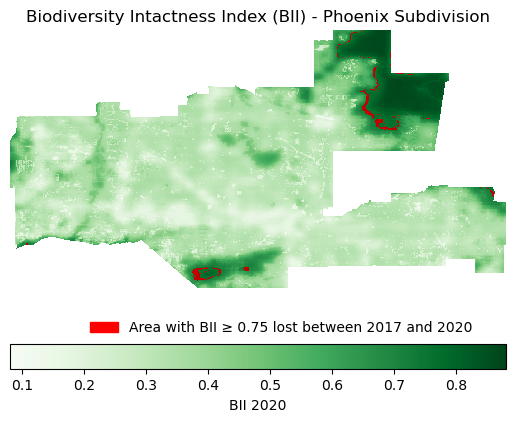

In [16]:
fig, ax = plt.subplots()
# -------------------
ax.axis('off')

bii_2020_phoenix.plot(ax=ax, # add 2020 BII percentage map 
                       cmap = 'Greens',
                         cbar_kwargs={'orientation':'horizontal',
                                       'label':'BII 2020'})

diff.plot(ax=ax, # add difference in percentage from 2017 to 2020
           cmap = 'gist_heat',
             add_colorbar = False)

red_patch = mpatches.Patch(color='red', # add legend item for areas with BII loss ≥ 0.75 from 2017
                            label = 'Area with BII ≥ 0.75 lost between 2017 and 2020')

ax.set_title("Biodiversity Intactness Index (BII) - Phoenix Subdivision")

ax.legend(handles=[red_patch], 
           frameon=False,
             loc=(0.15, -0.2))

# ------------------
plt.savefig('images/BII_phoenix.png', bbox_inches='tight',  dpi=100)

plt.show()

## Geographic Context

For context, let's see where the Phoenix subdivision is within the state of Arizona.

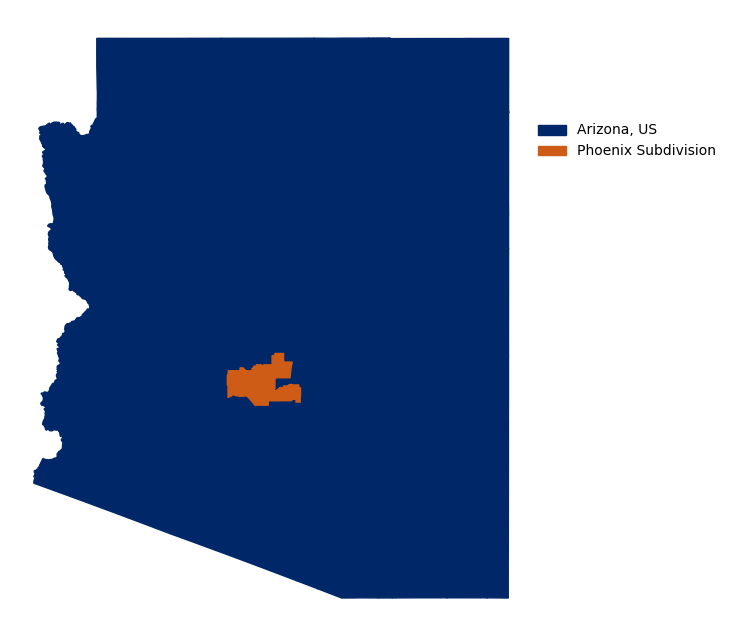

In [18]:

# create map of Phoenix, AZ in the geographical context of AZ
fig, ax = plt.subplots(figsize=(12,8))
# ---------------------
ax.axis('off')

subdivisions.plot(ax=ax,  # add outline of Arizona and subdivision outlines
       color='#002868', # official state of arizona blue
       edgecolor = '#002868')
subdivisions_patch = mpatches.Patch(color='#002868',
                          label='Arizona, US')

phoenix.plot(ax=ax,   # highlight subdivision of pheonix
         color ='#CE5C17', # official state of arizona orange
         edgecolor ='#CE5C17',
         label ='Phoenix Subdivision')
phoenix_patch = mpatches.Patch(color='#CE5C17',
                            label='Phoenix Subdivision')

ax.legend(handles = [subdivisions_patch, phoenix_patch], frameon=False, loc=(1, 0.75))

# ---------------------
plt.savefig('images/arizona_map.png', bbox_inches='tight',  dpi=100)

plt.show()